In [ ]:
import sys
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
  ! python -c "import torch; print(torch.__version__)"
  ! python -c "import torch; print(torch.cuda.is_available())"

1.5.1+cu101
True


In [ ]:
if IN_COLAB:
  ! PATH=/usr/local/cuda/bin:$PATH
  ! CPATH=/usr/local/cuda/include:$CPATH    
  ! LD_LIBRARY_PATH=/usr/local/cuda/lib64:$LD_LIBRARY_PATH
  ! DYLD_LIBRARY_PATH=/usr/local/cuda/lib:$DYLD_LIBRARY_PATH

In [ ]:
if IN_COLAB:
  ! nvcc --version
  ! python -c "import torch; print(torch.version.cuda)"

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
10.1


In [ ]:
if IN_COLAB:
  ! pip install --no-cache-dir torch-scatter==2.0.2
  ! pip install --no-cache-dir torch-sparse==0.4.4
  ! pip install --no-cache-dir torch-cluster==1.4.5
  ! pip install torch-geometric torch-sparse==latest+cu101 torch-scatter==latest+cu101 torch-cluster==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html

  Created wheel for torch-scatter: filename=torch_scatter-2.0.2-cp36-cp36m-linux_x86_64.whl size=7357266 sha256=649606d63b66560ec40f9012278133443993ff4ebe293dbd1e49f34c4cf9cc61
  Stored in directory: /tmp/pip-ephem-wheel-cache-a6e7237n/wheels/21/5b/b3/0299be203ab2eb6b5d74c85a968111ec09be6a30f65c9a3a68
Successfully built torch-scatter
  Created wheel for torch-sparse: filename=torch_sparse-0.4.4-cp36-cp36m-linux_x86_64.whl size=5454261 sha256=e1f8ba5e8eb109559cca8c4adf83f1cd5467563d4c179235bc974edfbe2b8b01
  Stored in directory: /tmp/pip-ephem-wheel-cache-j1m523zk/wheels/8a/1a/6f/88952b83ebba6b2742909fcd6e320e3a99fc7d2a2428391f8c
Successfully built torch-sparse
  ERROR: Failed building wheel for torch-cluster
  Running setup.py clean for torch-cluster
Failed to build torch-cluster
    Running setup.py install for torch-cluster ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-80m1kzjo/to

In [ ]:
from torch_geometric.datasets import Planetoid

In [ ]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')

Processing...
Done!


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

In [ ]:
class Vanilla_GCN(nn.Module):

  def __init__(self):
    super(Vanilla_GCN, self).__init__()
    self.gconv1 = GCNConv(dataset.num_node_features, 16)
    self.gconv3 = GCNConv(16, 16)
    self.gconv2 = GCNConv(16, dataset.num_classes)

  def forward(self, data):
    x, edge_index = data.x, data.edge_index
    x = self.gconv1(x, edge_index)
    x = F.relu(x)
    x = self.gconv3(x, edge_index)
    x = F.relu(x)
    x = F.dropout(x, training=self.training)
    x = self.gconv2(x, edge_index)
    x = F.log_softmax(x, dim=1)
    return x

In [ ]:
learning_rate = 1e-2
weight_decay  = 5e-4
num_epochs    = int(2e2)
train_losses  = []

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = dataset[0].to(device)
model = Vanilla_GCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [ ]:
model.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    train_losses.append(loss)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
      print(f'Epoch : {epoch} => Train Loss : {loss.item()}')

Epoch : 0 => Train Loss : 1.9510084390640259
Epoch : 10 => Train Loss : 1.0584176778793335
Epoch : 20 => Train Loss : 0.323603093624115
Epoch : 30 => Train Loss : 0.14607904851436615
Epoch : 40 => Train Loss : 0.05715806037187576
Epoch : 50 => Train Loss : 0.04293511435389519
Epoch : 60 => Train Loss : 0.048816435039043427
Epoch : 70 => Train Loss : 0.020010443404316902
Epoch : 80 => Train Loss : 0.04201028123497963
Epoch : 90 => Train Loss : 0.030439648777246475
Epoch : 100 => Train Loss : 0.04692428931593895
Epoch : 110 => Train Loss : 0.01844589039683342
Epoch : 120 => Train Loss : 0.014152191579341888
Epoch : 130 => Train Loss : 0.008966553024947643
Epoch : 140 => Train Loss : 0.020034488290548325
Epoch : 150 => Train Loss : 0.02827327698469162
Epoch : 160 => Train Loss : 0.05492791160941124
Epoch : 170 => Train Loss : 0.03553757444024086
Epoch : 180 => Train Loss : 0.01681618206202984
Epoch : 190 => Train Loss : 0.015670940279960632


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5, 1.0, 'Vanilla GCN on Cora')

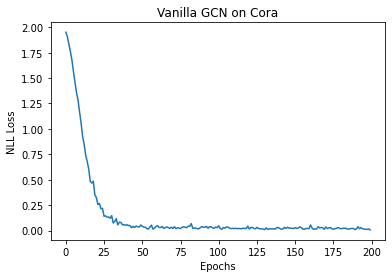

In [ ]:
plt.plot(train_losses, label='GCN Loss')
plt.xlabel('Epochs')
plt.ylabel('NLL Loss')
plt.title('Vanilla GCN on Cora')

In [ ]:
model.eval()
_, pred = model(data).max(dim=1)
correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / int(data.test_mask.sum())
print('Accuracy: {:.4f}'.format(acc))

Accuracy: 0.7740
